# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Import raw data

In [2]:
#File containing temperature values
raw_T_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_T.csv', delimiter=',')
#File containing pressure values
raw_P_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_P.csv', delimiter=',')

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_T_data[:, :4]
raw_outputs_T = raw_T_data[:, 5:]
raw_outputs_P = raw_P_data[:, 5:]

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features
O = raw_outputs_T.shape[1] #Number of outputs


# Plotting of the T-P profiles

In [ ]:
for raw_input, raw_output_T, raw_output_P in zip(raw_inputs,raw_outputs_T,raw_outputs_P):
    fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    ax.plot(raw_output_T, np.log(raw_output_P/1000), color='blue', linewidth=2)
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'log$_{10}$ Pressure (bar)')
    ax.set_title(rf'H$_2$O : {raw_input[0]} bar, CO$_2$ : {raw_input[1]} bar, LoD : {raw_input[2]:.0f} days, Obliquity : {raw_input[3]} deg')
    plt.show()

# Fitting the training data with a transformer neural network

## 0th step : Shrink down data so we can work with it locally

In [3]:
#Number of samples to shrink our dataset to 
sample_size = 100

filter = np.random.choice(np.arange(N), size=sample_size, replace=False)

raw_inputs = torch.tensor(raw_inputs[filter, :], dtype=torch.float32)
raw_outputs_T = torch.tensor(raw_outputs_T[filter, :], dtype=torch.float32)
raw_outputs_P = torch.tensor(raw_outputs_P[filter, :], dtype=torch.float32)

N = sample_size

## First step : Define a training, validation, and testing set

In [4]:
#Defining partition of data used for 1. training 2. validation and 3. testing
data_partitions = [0.7, 0.1, 0.2]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

#Splitting the data 
## Setting noise seec
generator = torch.Generator().manual_seed(partition_seed)
## Retrieving indices of data partitions
train_idx, valid_idx, test_idx = torch.utils.data.random_split(range(N), data_partitions, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
train_outputs_P = raw_outputs_P[train_idx]
### Validation
valid_inputs = raw_inputs[valid_idx]
valid_outputs_T = raw_outputs_T[valid_idx]
valid_outputs_P = raw_outputs_P[valid_idx]
### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]
test_outputs_P = raw_outputs_P[test_idx]

## Second step : defining the transformer NN

In [5]:
# ---------------------
# Defining transformer hyper-parameters
# ---------------------
## Number of attention heads
att_heads = 16
## Number of encoder/decoder layers 
num_layers = 12
## Dimensionality of internal embeddings (i.e. transformer width)
d_model = 64
## Dimension of the feedforward network model (i.e. size of hidden layer)
dim_feedforward = 128
## Number of inputs
src_len = 4
## Number of outputs
tgt_len = 51

# ---------------------
# Defining the model
# ---------------------
## Layers
src_embed = torch.nn.Linear(1, d_model)   # for 4 inputs as a sequence
tgt_embed = torch.nn.Linear(1, d_model)   # for 51 outputs as a sequence
out_proj  = torch.nn.Linear(d_model, 1)   # back to scalar temps

src_pos = torch.nn.Parameter(torch.randn(1, src_len, d_model))
tgt_pos = torch.nn.Parameter(torch.randn(1, tgt_len, d_model))

transformer = torch.nn.Transformer(
    d_model=d_model,
    nhead=att_heads,
    num_encoder_layers=num_layers,
    num_decoder_layers=num_layers,
    dim_feedforward=dim_feedforward,
    batch_first=True
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(src_embed.parameters()) +
                       list(tgt_embed.parameters()) +
                       list(out_proj.parameters()) +
                       [src_pos, tgt_pos] +
                       list(transformer.parameters()), lr=1e-3)

## Third step: running the training

In [6]:
# ----------------------------
# Training and validation loop
# ----------------------------
train_losses, val_losses = [], []
epochs = 5000

for epoch in range(epochs):
    # ---- TRAIN ----
    #Telling PyTorch we are in training mode
    transformer.train()
    #Resets accumulated gradients - otherwise you stack onto the previous gradient values
    optimizer.zero_grad()

    #Transformer expects 3D tensor (batch size, sequence length, embedding size) so we add an extra dimension
    src = train_inputs.float().unsqueeze(-1)  # (N,4,1)
    #Pass each scalar input through linear embedding layer
    src = src_embed(src) + src_pos

    #Load target T-P profiles for the current batch
    Y_in = train_outputs_T.float()
    #Adds the extra dimension
    tgt = Y_in.unsqueeze(-1)
    #Projects output temp. values in necessary dimensions
    tgt = tgt_embed(tgt) + tgt_pos

    #Feed source (input) and target (output) into the transformer
    h = transformer(src, tgt)
    #Apply final linear lyaer to convert hidden vector into scalar predicted temp.
    Y_pred = out_proj(h).squeeze(-1)

    #Compute the MSE between predicted and input T-P profile
    train_loss = criterion(Y_pred, Y_in)
    #Runs backpropagation i.e. computes gradients for all weights in network
    train_loss.backward()
    #Updates parameters using computed gradients (in this case with Adam)
    optimizer.step()

    # ---- VALIDATION ----
    #Switch Transformer to evaluation mode
    transformer.eval()
    #Turn off gradient tracking within this block
    with torch.no_grad():

        #Same steps in terms of dimension modification as in training but with validation data
        src = valid_inputs.float().unsqueeze(-1)
        src = src_embed(src) + src_pos

        #Prepare validation targets as decoder input embeddings
        Y_in = valid_outputs_T.float()
        tgt = Y_in.unsqueeze(-1)
        tgt = tgt_embed(tgt) + tgt_pos

        #Runs a pass through the current transformer and generates prediction temperature values
        h = transformer(src, tgt)
        Y_pred_val = out_proj(h).squeeze(-1)

        #Compare predicted T-P profile to validation ones
        val_loss = criterion(Y_pred_val, Y_in)

    #Store training loss and validation loss at each epoch
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# ---- TESTING ----
#Switching the transformer mode to testing/evaluation
transformer.eval()

#Turn off gradient tracking within this block
with torch.no_grad():
    
    #Same steps in terms of dimension modification as in training but with testing data
    src = test_inputs.float().unsqueeze(-1)
    src = src_embed(src) + src_pos

    #Prepare testing targets as decoder input embeddings
    Y_in = torch.zeros_like(test_outputs_T.float())  # zero decoder input
    tgt = Y_in.unsqueeze(-1)
    tgt = tgt_embed(tgt) + tgt_pos

    #Runs a pass through the current transformer and generates prediction temperature values
    h = transformer(src, tgt)
    Y_pred_test = out_proj(h).squeeze(-1)

# Convert temperature outputs to numpy
Y_pred = Y_pred_test.numpy()

Epoch 001 | Train Loss: 48313.2500 | Val Loss: 43679.6641
Epoch 002 | Train Loss: 47285.2227 | Val Loss: 43306.2344
Epoch 003 | Train Loss: 46917.3867 | Val Loss: 43136.1406
Epoch 004 | Train Loss: 46738.3633 | Val Loss: 43032.3906
Epoch 005 | Train Loss: 46622.3867 | Val Loss: 42967.8906
Epoch 006 | Train Loss: 46547.5508 | Val Loss: 42916.1328
Epoch 007 | Train Loss: 46484.2578 | Val Loss: 42870.4219
Epoch 008 | Train Loss: 46433.7852 | Val Loss: 42831.0391
Epoch 009 | Train Loss: 46388.8594 | Val Loss: 42795.5195
Epoch 010 | Train Loss: 46349.2578 | Val Loss: 42761.6680
Epoch 011 | Train Loss: 46311.1914 | Val Loss: 42729.5703
Epoch 012 | Train Loss: 46276.3242 | Val Loss: 42700.3633
Epoch 013 | Train Loss: 46244.5117 | Val Loss: 42673.0391
Epoch 014 | Train Loss: 46216.0820 | Val Loss: 42646.3398
Epoch 015 | Train Loss: 46186.3516 | Val Loss: 42619.4922
Epoch 016 | Train Loss: 46156.8281 | Val Loss: 42592.4453
Epoch 017 | Train Loss: 46127.4023 | Val Loss: 42565.3008
Epoch 018 | Tr

## Fourth step: diagnostic plots

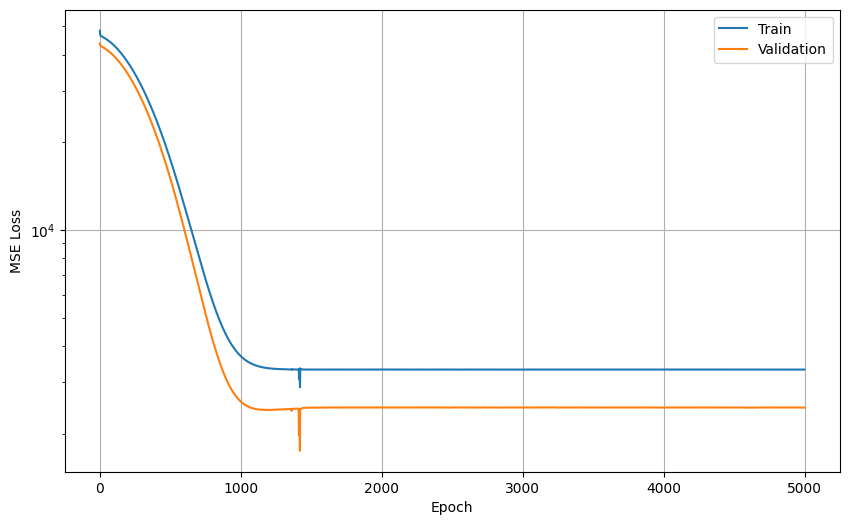

In [7]:
# Loss curves
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), train_losses, label="Train")
plt.plot(np.arange(epochs), val_losses, label="Validation")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

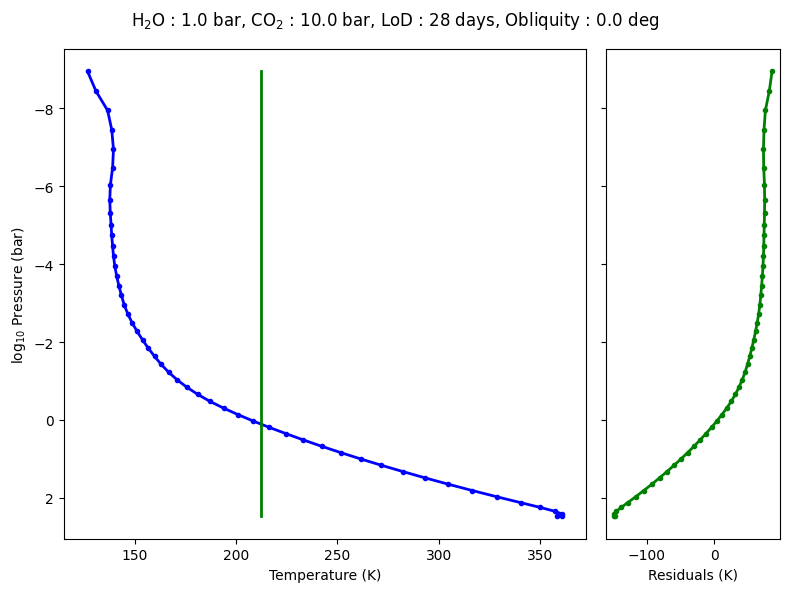

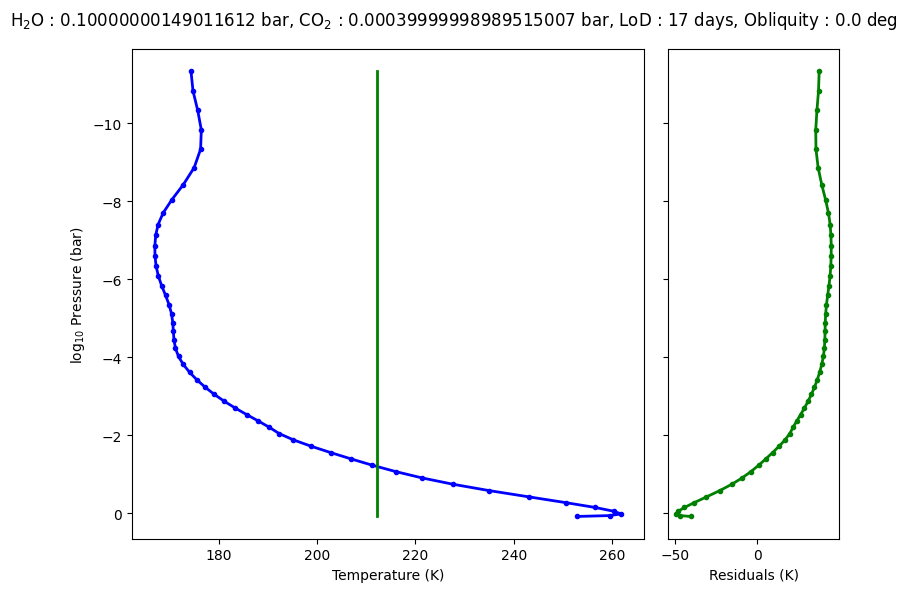

In [10]:
#Comparing predicted T-P profiles vs true T-P profiles with residuals
substep = 10

#Converting tensors to numpy arrays if this isn't already done
if (type(test_inputs) != np.ndarray):
    test_inputs = test_inputs.numpy()
    test_outputs_T = test_outputs_T.numpy()
    test_outputs_P = test_outputs_P.numpy()

for test_idx, (test_input, test_output_T, test_output_P, pred_output_T) in enumerate(zip(test_inputs, test_outputs_T, test_outputs_P, Y_pred)):

    #Plotting
    if (test_idx % substep == 0):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 6], sharey=True, gridspec_kw = {'width_ratios':[3, 1]})
        ax1.plot(test_output_T, np.log(test_output_P/1000), '.', linestyle='-', color='blue', linewidth=2)
        ax1.plot(pred_output_T, np.log(test_output_P/1000), color='green', linewidth=2)
        ax1.invert_yaxis()
        ax1.set_ylabel(r'log$_{10}$ Pressure (bar)')
        ax1.set_xlabel('Temperature (K)')
        ax2.plot(pred_output_T - test_output_T, np.log(test_output_P/1000), '.', linestyle='-', color='green', linewidth=2)
        ax2.set_xlabel('Residuals (K)')
        plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.tight_layout()
        plt.show()
    